# Master in Applied Artificial Intelligence

## Course: *Fintech and Digital Innovation in Finance*

### **Course Project – Part 4**
### Advanced RAG techniques & Sentiment Analysis on S&P 500 news (*Section B*)

---

**Institution:** Tecnológico de Monterrey

**Instructors:** Marie-Ève Malette, Yetnalezi Quintas Ruiz

**Author:** Alejandro Díaz Villagómez | A01276769

**Date:** August 18th, 2025

---

# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model. 
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [102]:
# !pip install -q hf_xet yfinance
# !pip freeze > ../requirements.txt

In [103]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import yfinance as yf

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [104]:
df_news = pd.read_csv('df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)

print(f"News data shape: {df_news.shape}")
print(f"News date range: {df_news['PUBLICATION_DATE'].min()} to {df_news['PUBLICATION_DATE'].max()}")
print("-" * 30)
display(df_news.head())

News data shape: (3976, 6)
News date range: 2024-07-12 13:22:00+00:00 to 2025-05-31 15:42:42+00:00
------------------------------


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...


In [105]:
df_meta = pd.read_csv('df_metadata.csv')

print(f"Metadata shape: {df_meta.shape}")
print("-" * 30)
display(df_meta.head())

Metadata shape: (490, 4)
------------------------------


,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [106]:
# CODE HERE
# Use as many coding cells as you need

# Setup
MODEL_NAME = "cross-encoder/nli-deberta-v3-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device).eval()

In [107]:
# Find label indices robustly (models sometimes use different keys)
id2label = model.config.id2label
label2id = {v.lower(): k for k, v in id2label.items()}

def _find_idx(name_candidates):
    for k, v in id2label.items():
        if v.lower() in name_candidates:
            return int(k)
    # Fallback: common ordering is [contradiction, neutral, entailment]
    # but don't rely on it unless we must
    if len(id2label) == 3:
        # Heuristic fallback
        return 2 if "ent" in name_candidates else 0
    raise ValueError("Could not map NLI label indices from model config.")

ENT_IDX = _find_idx({"entailment"})
CON_IDX = _find_idx({"contradiction"})

# Hypotheses
POS_HYP = "This news is good for the company."
NEG_HYP = "This news is bad for the company."

In [ ]:
# Batch scoring function
def score_headlines_nli(headlines, batch_size=32, max_length=256):
    """
    Returns two lists: positive_probs, negative_probs
    Each is the entailment probability for (headline, POS/NEG hypothesis).
    """
    pos_probs, neg_probs = [], []

    # Helper to run one hypothesis across a slice of headlines
    def _run_batch(premises, hypothesis):
        enc = tokenizer(
            premises, [hypothesis] * len(premises),
            padding=True, truncation=True, max_length=max_length, return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            logits = model(**enc).logits  # [B, 3]
            probs = F.softmax(logits, dim=-1)
            entailment = probs[:, ENT_IDX]  # entailment probability
        return entailment.detach().cpu().tolist()

    # Iterate in batches
    for i in range(0, len(headlines), batch_size):
        chunk = list(map(str, headlines[i:i+batch_size]))  # ensure strings
        pos_probs.extend(_run_batch(chunk, POS_HYP))
        neg_probs.extend(_run_batch(chunk, NEG_HYP))

    return pos_probs, neg_probs

In [ ]:
# Apply to df_news
pos, neg = score_headlines_nli(df_news['SUMMARY'].tolist(), batch_size=32)
df_news['POSITIVE_PROB'] = pos
df_news['NEGATIVE_PROB'] = neg
df_news['SENTIMENT'] = df_news['POSITIVE_PROB'] - df_news['NEGATIVE_PROB']

print(f"News sentiment shape: {df_news.shape}")
print(f"News sentiment date range: {df_news['PUBLICATION_DATE'].min()} to {df_news['PUBLICATION_DATE'].max()}")
print("-" * 30)
display(df_news[['SUMMARY', 'POSITIVE_PROB', 'NEGATIVE_PROB', 'SENTIMENT']].head())

,SUMMARY,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,The Dow Jones (^DJI) is made up of 30 of the m...,0.000038,0.000122,-0.000084
1,The S&P 500 (^GSPC) is often seen as a benchma...,0.000081,0.000185,-0.000104
2,"MMM is making strides in the aerospace, indust...",0.002505,0.000349,0.002155
3,Quarterly earnings results are a good time to ...,0.000188,0.000054,0.000134
4,While strong cash flow is a key indicator of s...,0.000204,0.000097,0.000108


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

In [111]:
# CODE HERE
# Use as many coding cells as you need

# Step 1: Aggregate daily sentiment
# Ensure publication date is in datetime
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']) 
daily_sentiment = (
    df_news.groupby(df_news['PUBLICATION_DATE'].dt.date)['SENTIMENT']
    .mean()
    .reset_index()
    .rename(columns={'PUBLICATION_DATE': 'date', 'SENTIMENT': 'avg_sentiment'})
)
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

print(f"Daily sentiment shape: {daily_sentiment.shape}")
print(f"Daily sentiment date range: {daily_sentiment['date'].min().strftime('%Y-%m-%d')} to {daily_sentiment['date'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(daily_sentiment.head())

Daily sentiment shape: (118, 2)
Daily sentiment date range: 2024-07-12 to 2025-05-31
------------------------------


,date,avg_sentiment
0,2024-07-12,0.000296
1,2024-07-22,0.000042
2,2024-08-19,0.002900
3,2024-09-13,0.001527
4,2024-10-26,0.000438


In [31]:
# Step 2: Download market data (S&P 500 proxy)
sp500 = yf.download("^GSPC", start=daily_sentiment['date'].min(), end=daily_sentiment['date'].max(), auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Step 3: Compute daily returns (auto_adjust=True implies 'Close' is adjusted)
sp500_returns = (
    sp500[['Close']]  # adjusted close when auto_adjust=True
    .rename(columns={'Close': 'close'})
    .assign(Return=lambda d: d['close'].pct_change())
    .reset_index()
    .rename(columns={'Date': 'date'})
)

print(f"SP500 returns shape: {sp500_returns.shape}")
print("-" * 30)
display(sp500_returns.head())

SP500 returns shape: (230, 3)
SP500 returns date range: 2024-07-01 to 2025-05-30
------------------------------


Price,date,close,Return
Ticker,,^GSPC,
0,2024-07-01,5475.089844,NaN
1,2024-07-02,5509.009766,0.006195
2,2024-07-03,5537.020020,0.005084
3,2024-07-05,5567.189941,0.005449
4,2024-07-08,5572.850098,0.001017


In [115]:
# Step 3.1: yfinance yields MultiIndex columns; flatten is needed
sp500_returns.columns = [c[0] if isinstance(c, tuple) else c for c in sp500_returns.columns]
sp500_returns['date'] = pd.to_datetime(sp500_returns['date'])

print(f"SP500 returns after flattening: {sp500_returns.shape}")
print(f"SP500 returns date range: {sp500_returns['date'].min().strftime('%Y-%m-%d')} to {sp500_returns['date'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(sp500_returns.head())

SP500 returns after flattening: (230, 3)
SP500 returns date range: 2024-07-01 to 2025-05-30
------------------------------


,date,close,Return
0,2024-07-01,5475.089844,NaN
1,2024-07-02,5509.009766,0.006195
2,2024-07-03,5537.020020,0.005084
3,2024-07-05,5567.189941,0.005449
4,2024-07-08,5572.850098,0.001017


In [117]:
# Step 4: Merge daily sentiment with returns
merged = pd.merge(
    daily_sentiment[['date', 'avg_sentiment']].copy(),
    sp500_returns[['date', 'Return']].copy(),
    on='date',
    how='inner'
).sort_values('date').reset_index(drop=True)

print(f"Merged data shape: {merged.shape}")
print(f"Merged data date range: {merged['date'].min().strftime('%Y-%m-%d')} to {merged['date'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(merged.head(10))

Merged data shape: (83, 3)
Merged data date range: 2024-07-12 to 2025-05-30
------------------------------


,date,avg_sentiment,Return
0,2024-07-12,0.000296,0.005517
1,2024-07-22,0.000042,0.010792
2,2024-08-19,0.002900,0.009722
3,2024-09-13,0.001527,0.005408
4,2024-11-12,0.000689,-0.002893
5,2024-12-11,-0.000034,0.008166
6,2024-12-16,0.000754,0.003799
7,2024-12-20,-0.000022,0.010869
8,2025-01-02,0.000098,-0.002224
9,2025-01-03,0.000024,0.012596


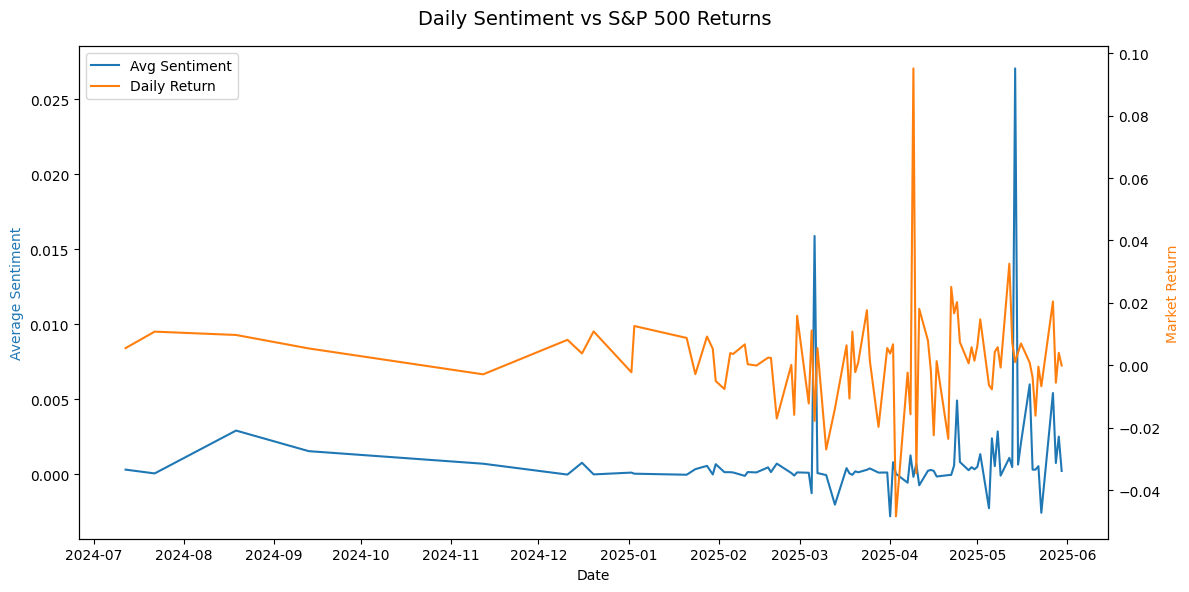

In [118]:
# Step 5: Visualization 
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: sentiment
ax1.plot(merged['date'], merged['avg_sentiment'], color='tab:blue', label='Avg Sentiment')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Sentiment', color='tab:blue')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='y')

# Right y-axis: returns
ax2 = ax1.twinx()
ax2.plot(merged['date'], merged['Return'], color='tab:orange', label='Daily Return')
ax2.set_ylabel('Market Return', color='tab:orange')
# ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.tick_params(axis='y')

# Add title & legend
fig.suptitle("Daily Sentiment vs S&P 500 Returns", fontsize=14)
l1, lb1 = ax1.get_legend_handles_labels()
l2, lb2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lb1 + lb2, loc='upper left')
plt.tight_layout()

plt.show()

The time series analysis reveals distinct temporal patterns in both sentiment and market behavior across the observation period from July 2024 to June 2025. During the initial phase (July-December 2024), average sentiment demonstrates relatively stable dynamics, fluctuating within a narrow band near zero with a slight declining trend. Concurrently, S&P 500 daily returns exhibit moderate volatility with intermittent spikes, maintaining a generally contained range of approximately ±1%.

A notable shift occurs beginning in early 2025, characterized by significantly increased market volatility and more pronounced sentiment fluctuations. The period from March to June 2025 shows particularly heightened activity, with daily returns experiencing extreme movements reaching approximately ±10%, while sentiment scores display greater variability and occasional sharp deviations from the baseline. This period suggests potential market stress or significant news events driving both sentiment and price movements.

The visual examination suggests limited systematic co-movement between daily sentiment and market returns throughout most of the observation period. While both series exhibit increased volatility in the latter months, the temporal alignment of peaks and troughs appears inconsistent, indicating that the relationship between news sentiment and same-day market performance may be more complex than a simple linear correlation would suggest. The divergent scaling and volatility patterns underscore the importance of further quantitative analysis to assess any potential predictive relationships.

## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


In [66]:
# CODE HERE
# Use as many coding cells as you need

# 1) Collect tickers from df_meta (robust to column naming)
tickers = (
    df_meta['TICKER'].dropna().astype(str).str.strip().str.upper()
    .str.replace(r'\s+', '', regex=True)
    .str.replace('.', '-', regex=False)  # yfinance uses '-' for class shares, e.g., BRK-B
    .unique().tolist()
)

start = pd.to_datetime(daily_sentiment['date']).min()
end   = pd.to_datetime(daily_sentiment['date']).max()

print(f"Collecting tickers from metadata: {len(tickers)} found")
print(f"Date range: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")

Date range: 2024-07-12 to 2025-05-31


In [90]:
# 2) Download prices (equal-weight universe = all tickers found). Fallback to ^GSPC if none.
prices = yf.download(
    tickers=tickers, 
    start=start, 
    end=end, 
    auto_adjust=True, 
    group_by="ticker", 
    threads=True
)

print(f"Prices shape: {prices.shape}")
print(f"Prices date range: {prices.index.min().strftime('%Y-%m-%d')} to {prices.index.max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(prices.head())

[*********************100%***********************]  490 of 490 completed

Prices shape: (222, 2450)
Prices date range: 2024-07-12 to 2025-05-30
------------------------------


Ticker             XYL                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2024-07-12  137.961494  138.159158  136.696428  136.805145   763100   
2024-07-15  137.042346  137.734177  135.322640  135.698212  1190800   
2024-07-16  136.567915  139.789892  135.797016  139.611984  1212500   
2024-07-17  138.870751  139.849206  137.131289  137.378372  1214500   
2024-07-18  136.775488  138.692858  136.162726  136.429565   962400   

Ticker             UPS                                               ...  \
Price             Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2024-07-12  131.506884  135.650774  131.213597  134.676300  4801300  ...   
2024-07-15  135.300712  137.419965  135.054733  136.379257  4164000  ...   
2024-07-16  136.265724  139.614900  136.265724  139.387833  3805100  ...   
2024-07-17  139.066159  139.823022  138.507954  139.435135  2863600  ...   
2024-07-18  138.148461  140.163629  136.663089  136.956375  3412900  ...   

Ticker             DHI                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2024-07-12  148.981825  153.375271  148.942340  151.785736  4024000   
2024-07-15  152.012820  152.812521  149.742053  150.225830  2547300   
2024-07-16  152.930989  160.572608  152.417610  160.197433  3237700   
2024-07-17  158.370958  160.157948  155.093153  155.507812  4137400   
2024-07-18  165.104258  175.214098  163.465370  171.215576  9608600   

Ticker             PTC                                               
Price             Open        High         Low       Close   Volume  
Date                                                                 
2024-07-12  179.770004  183.990005  178.600006  182.729996   976600  
2024-07-15  183.210007  184.679993  182.100006  184.529999   969900  
2024-07-16  184.970001  186.419998  183.110001  184.080002  1364400  
2024-07-17  183.009995  184.000000  179.619995  179.770004  1038900  
2024-07-18  179.770004  179.770004  175.419998  176.080002   917200  

[5 rows x 2450 columns]

In [94]:
# 3) Extract Close matrix (handles multi-ticker frames)
close = prices.xs('Close', axis=1, level=1).copy()

# Clean index/timezone; drop days with no data for all tickers
close.index = pd.to_datetime(close.index).tz_localize(None)
close = close.dropna(how='all')

print(f"Prices shape: {close.shape}")
print(f"Prices date range: {close.index.min().strftime('%Y-%m-%d')} to {close.index.max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(close.head())

Prices shape: (222, 490)
Prices date range: 2024-07-12 to 2025-05-30
------------------------------


Ticker,XYL,UPS,PM,AFL,FI,CAG,AMAT,AMZN,GM,DOV,...,DIS,STX,IEX,EXPD,JNJ,VTR,HIG,ETR,DHI,PTC
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-12,136.805145,134.676300,101.949562,90.771385,153.199997,26.436344,241.121841,194.490005,48.499504,182.536179,...,96.290878,104.188736,201.605392,118.356514,145.150696,50.938572,100.064743,52.502941,151.785736,182.729996
2024-07-15,135.698212,136.379257,101.102791,91.486664,155.389999,26.669472,243.251755,192.720001,48.786488,183.001129,...,96.033134,105.978706,203.804245,117.507515,144.530914,51.113350,100.979340,51.377571,150.225830,184.529999
2024-07-16,139.611984,139.387833,102.093895,91.663040,157.139999,27.033142,243.539032,193.020004,49.251595,189.431244,...,97.619316,105.754951,207.866714,120.044640,146.245056,51.560009,101.284203,52.166290,160.197433,184.080002
2024-07-17,137.378372,139.435135,104.220459,92.162750,157.960007,28.086868,218.010239,187.929993,49.380241,187.769302,...,96.469330,102.058250,207.561050,119.264748,151.639297,51.880440,103.300262,53.209900,155.507812,179.770004
2024-07-18,136.429565,136.956375,103.402550,92.388107,157.690002,28.058893,215.612869,183.750000,49.132843,184.336594,...,95.953827,100.657394,203.321075,118.751404,150.515900,51.666821,103.319916,53.253189,171.215576,176.080002


In [93]:
# 4) Equal-weight daily return and cumulative portfolio value (start at 1.0)
ret = close.pct_change()
avg_ret = ret.mean(axis=1, skipna=True).dropna() # average across tickers each day
portfolio_value = (1.0 + avg_ret).cumprod().rename('portfolio_value')
portfolio_df = portfolio_value.to_frame()
portfolio_df['date'] = portfolio_df.index

print(f"Portfolio value shape: {portfolio_df.shape}")
print(f"Portfolio value date range: {portfolio_df['date'].min().strftime('%Y-%m-%d')} to {portfolio_df['date'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(portfolio_df.head())

Portfolio value shape: (221, 2)
Portfolio value date range: 2024-07-15 to 2025-05-30
------------------------------


,portfolio_value,date
Date,,
2024-07-15,1.001197,2024-07-15
2024-07-16,1.018191,2024-07-16
2024-07-17,1.013614,2024-07-17
2024-07-18,1.004839,2024-07-18
2024-07-19,0.998813,2024-07-19


In [84]:
# 5) Merge with daily sentiment (inner join on trading days)
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.tz_localize(None)
viz = (daily_sentiment[['date','avg_sentiment']]
       .merge(portfolio_df[['date','portfolio_value']], on='date', how='inner')
       .sort_values('date').reset_index(drop=True))

print(f"Visualization data shape: {viz.shape}")
print(f"Date range: {viz['date'].min().strftime('%Y-%m-%d')} to {viz['date'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(viz.head())

Visualization data shape: (82, 3)
Date range: 2024-07-22 to 2025-05-30
------------------------------


,date,avg_sentiment,portfolio_value
0,2024-07-22,0.000042,1.007599
1,2024-08-19,0.002900,1.024674
2,2024-09-13,0.001527,1.041329
3,2024-11-12,0.000689,1.101998
4,2024-12-11,-0.000034,1.105454


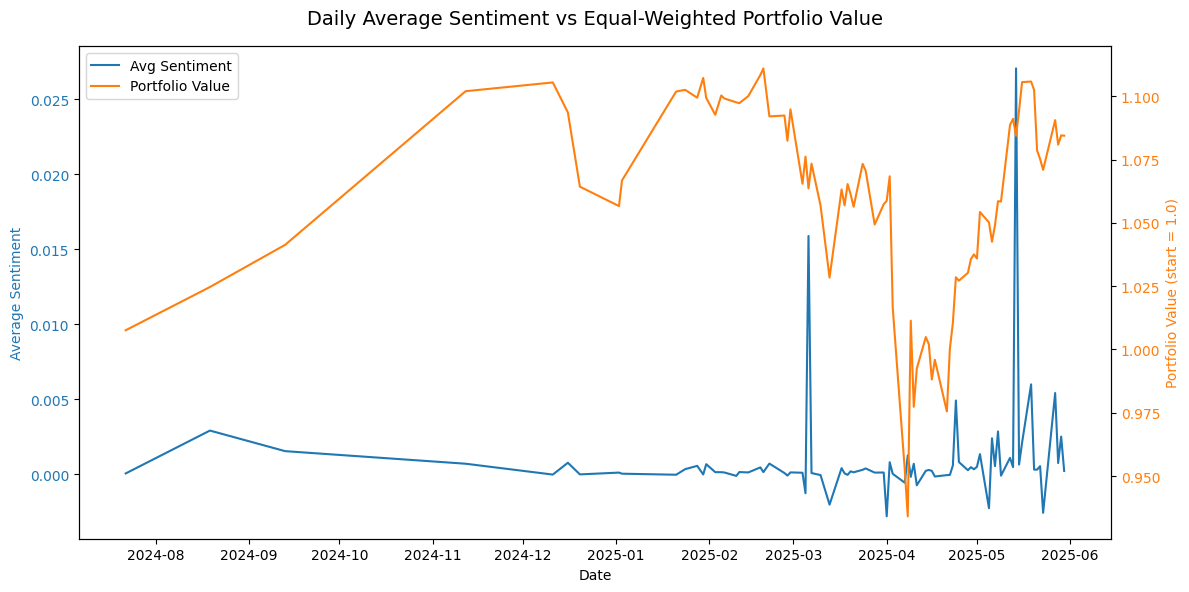

In [ ]:
# 6) Dual-axis plot: sentiment (left) vs portfolio value (right)
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(viz['date'], viz['avg_sentiment'], label='Avg Sentiment', color='tab:blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Sentiment', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(viz['date'], viz['portfolio_value'], label='Portfolio Value', color='tab:orange')
ax2.set_ylabel('Portfolio Value (start = 1.0)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.suptitle('Daily Average Sentiment vs Equal-Weighted Portfolio Value', fontsize=14)
l1, lb1 = ax1.get_legend_handles_labels()
l2, lb2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lb1 + lb2, loc='upper left')
plt.tight_layout()
plt.show()

The figure contrasts daily average news sentiment with the value of an equal-weighted portfolio (base = 1.0). From July to November 2024 the portfolio trends upward while sentiment remains near zero with low dispersion, indicating that early performance was not mirrored by headline sentiment. Beginning around late 2024/early 2025, both series display greater variability; the portfolio experiences material drawdowns and subsequent recoveries, while sentiment exhibits intermittent spikes that occasionally coincide with turning points.

Visual inspection suggests limited and sporadic co-movement rather than a stable same-day relationship. Given the dual-axis scaling and several extreme observations, these patterns should be interpreted cautiously; normalizing both series and testing lead–lag relations (e.g., predictive regressions or quantile-sorted strategies) would provide a more reliable assessment of whether sentiment carries timing information or primarily signals volatility regimes.

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [ ]:
# CODE HERE
# Use as many coding cells as you need

# Step 1: Normalize tickers and determine relevant information
def norm_ticker(s):
    return (
        s.astype(str).str.upper().str.strip()
        .str.replace(r'\s+', '', regex=True)
        .str.replace('.', '-', regex=False)
    )

# Normalize tickers in both tables
df_news['TICKER'] = norm_ticker(df_news['TICKER'])
df_meta['TICKER'] = norm_ticker(df_meta['TICKER'])

# Determine target year and months
target_year = 2025
months_target = [2, 3, 4, 5] # Feb - May

In [129]:
# Step 2: Group news by sector and calculate monthly sentiment (Feb–May 2025)
news_sector = (df_news.merge(
    df_meta[['TICKER', 'SECTOR']].dropna(),
    left_on='TICKER', right_on='TICKER', how='left')
    .rename(columns={'SECTOR': 'SECTOR'})
)

mask_months = (news_sector['PUBLICATION_DATE'].dt.year == target_year) & \
    (news_sector['PUBLICATION_DATE'].dt.month.isin(months_target))

news_feb_may = news_sector.loc[mask_months].copy()
news_feb_may['month'] = news_feb_may['PUBLICATION_DATE'].dt.to_period('M').dt.to_timestamp('M')

monthly_sector_sent = (
    news_feb_may.groupby(['SECTOR','month'], dropna=True)
    .agg(SENTIMENT=('SENTIMENT','mean'), HEADLINES=('SENTIMENT','size'))  # HEADLINES is optional
    .reset_index()
)

print(f"Monthly sector sentiment shape: {monthly_sector_sent.shape}")
print(f"Monthly sector sentiment date range: {monthly_sector_sent['month'].min().strftime('%Y-%m-%d')} to {monthly_sector_sent['month'].max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(monthly_sector_sent.head(10))

Monthly sector sentiment shape: (39, 4)
Monthly sector sentiment date range: 2025-02-28 to 2025-05-31
------------------------------


,SECTOR,month,SENTIMENT,HEADLINES
0,Basic Materials,2025-02-28,-0.000122,1
1,Basic Materials,2025-03-31,-0.000197,4
2,Basic Materials,2025-04-30,-0.000030,10
3,Basic Materials,2025-05-31,0.001205,135
4,Communication Services,2025-03-31,0.000328,1
5,Communication Services,2025-04-30,0.000259,5
6,Communication Services,2025-05-31,0.001323,144
7,Consumer Cyclical,2025-02-28,0.000119,3
8,Consumer Cyclical,2025-03-31,-0.000702,4
9,Consumer Cyclical,2025-04-30,0.000260,18


In [130]:
# May sentiment by sector
may_sent = (
    monthly_sector_sent
    .loc[monthly_sector_sent['month'].dt.month == 5, ['SECTOR','SENTIMENT','HEADLINES']]
    .rename(columns={'SENTIMENT':'SENTIMENT'})
)

print(f"May sentiment shape: {may_sent.shape}")
print("-" * 30)
display(may_sent.sort_values('SENTIMENT', ascending=False).head(10))

May sentiment shape: (11, 3)
------------------------------


,SECTOR,SENTIMENT,HEADLINES
27,Industrials,0.008002,539
16,Energy,0.006071,172
13,Consumer Defensive,0.005772,270
34,Technology,0.001646,636
20,Financial Services,0.001397,453
6,Communication Services,0.001323,144
3,Basic Materials,0.001205,135
31,Real Estate,0.000782,188
38,Utilities,0.000627,209
23,Healthcare,-0.001707,446


In [128]:
# Step 3: Compute monthly stock returns from price data and extract May returns

# Create universe of tickers and download prices
universe = df_meta.dropna(subset=['TICKER', 'SECTOR']).copy()
tickers = universe['TICKER'].unique().tolist()

start_prices = pd.Timestamp(target_year, 1, 1)
end_prices = pd.Timestamp(target_year, 5, 31) + pd.Timedelta(days=1)  # Includes all of May

prices = yf.download(
    tickers=tickers, 
    start=start_prices, 
    end=end_prices,
    auto_adjust=True, 
    group_by="ticker", 
    threads=True
)

print(f"Prices shape: {prices.shape}")
print(f"Prices date range: {prices.index.min().strftime('%Y-%m-%d')} to {prices.index.max().strftime('%Y-%m-%d')}")
print("-" * 30)
display(prices.head())

[*********************100%***********************]  490 of 490 completed


Prices shape: (102, 2450)
Prices date range: 2025-01-02 to 2025-05-30
------------------------------


Ticker              FI                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2025-01-02  207.000000  207.850006  204.509995  205.979996  2002400   
2025-01-03  207.479996  208.750000  205.589996  208.570007  1579900   
2025-01-06  208.570007  208.990005  205.399994  205.630005  1823700   
2025-01-07  206.259995  207.330002  203.460007  203.820007  2711200   
2025-01-08  204.029999  205.740005  203.729996  205.229996  2490900   

Ticker            DAL                                            ...  \
Price            Open       High        Low      Close   Volume  ...   
Date                                                             ...   
2025-01-02  59.736867  60.232445  58.081638  58.547482  8639300  ...   
2025-01-03  58.497923  58.577214  56.228179  58.478100  9207000  ...   
2025-01-06  59.766602  60.410854  59.082707  59.508904  9652900  ...   
2025-01-07  59.766600  61.035280  59.419698  60.638817  9074200  ...   
2025-01-08  60.410854  61.312804  59.360229  60.876694  9062400  ...   

Ticker             CDW                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2025-01-02  173.352858  174.256724  167.293995  168.883209   996400   
2025-01-03  170.134713  173.442255  168.952751  173.054886   947600   
2025-01-06  173.720359  179.342188  173.720359  178.080750  1518700   
2025-01-07  178.368817  182.530560  178.368817  179.759369  1626100   
2025-01-08  178.756188  180.414923  174.852686  180.116943  1473800   

Ticker              TDG                                                 
Price              Open         High          Low        Close  Volume  
Date                                                                    
2025-01-02  1271.859985  1272.050049  1245.339966  1254.109985  297700  
2025-01-03  1256.900024  1282.239990  1256.900024  1275.560059  219700  
2025-01-06  1276.619995  1276.839966  1245.819946  1251.319946  363500  
2025-01-07  1248.859985  1263.189941  1242.489990  1252.130005  190900  
2025-01-08  1255.520020  1284.199951  1240.339966  1282.319946  319500  

[5 rows x 2450 columns]

In [ ]:
# Extract Close matrix 
close = prices.xs('Close', axis=1, level=1).copy()
close.index = pd.to_datetime(close.index).tz_localize(None)
close = close.dropna(how='all')

# Compute monthly returns (last of month)
close_m = close.resample('M').last()
ret_m = close_m.pct_change()

# Filter Feb–May 2025
ret_m = ret_m[(ret_m.index.year == target_year) & (ret_m.index.month.isin(months_target))]

# Map to long format, map sector, and average by sector-month (equal-weight)
ret_long = (
    ret_m.stack().rename('RETURN').reset_index()
    .rename(columns={'Ticker':'TICKER','Date':'month'})
)
ret_long['TICKER'] = norm_ticker(ret_long['TICKER'])

ticker_to_sector = universe[['TICKER', 'SECTOR']].dropna().rename(
    columns={'TICKER':'TICKER', 'SECTOR':'SECTOR'}
)

ret_with_sector = ret_long.merge(ticker_to_sector, on='TICKER', how='left')

sector_monthly_returns = (
    ret_with_sector.groupby(['SECTOR','month'], dropna=True)
    .agg(RETURN=('RETURN','mean'),N_TICKERS=('RETURN','count'))
    .reset_index()
)

# May returns by sector
may_rets = sector_monthly_returns.loc[
    sector_monthly_returns['month'].dt.month == 5, ['SECTOR','RETURN','N_TICKERS']
]

print(f"May returns by sector: {may_rets.shape}")
print("-" * 30)
display(may_rets.sort_values('RETURN', ascending=False).head(10))

May returns by sector: (11, 3)
------------------------------


,SECTOR,RETURN,N_TICKERS
39,Technology,0.075285,81
31,Industrials,0.074589,70
23,Financial Services,0.061068,66
11,Consumer Cyclical,0.056382,55
7,Communication Services,0.043514,23
43,Utilities,0.032967,30
3,Basic Materials,0.029613,19
19,Energy,0.029434,21
35,Real Estate,0.010360,31
27,Healthcare,0.000100,58


In [138]:
# Step 4: Compare May sentiment and returns by sector
comparison = (may_sent.merge(may_rets, on='SECTOR', how='inner')
              .sort_values('RETURN', ascending=False)
              .reset_index(drop=True))

print(f"Sectors in comparison: {comparison['SECTOR'].nunique()}")
print(f"Comparison shape: {comparison.shape}")
print("-" * 30)
display(comparison)

Sectors in comparison: 11
Comparison shape: (11, 5)
------------------------------


,SECTOR,SENTIMENT,HEADLINES,RETURN,N_TICKERS
0,Technology,0.001646,636,0.075285,81
1,Industrials,0.008002,539,0.074589,70
2,Financial Services,0.001397,453,0.061068,66
3,Consumer Cyclical,-0.002116,409,0.056382,55
4,Communication Services,0.001323,144,0.043514,23
5,Utilities,0.000627,209,0.032967,30
6,Basic Materials,0.001205,135,0.029613,19
7,Energy,0.006071,172,0.029434,21
8,Real Estate,0.000782,188,0.010360,31
9,Healthcare,-0.001707,446,0.000100,58


In [140]:
# Step 5: Correlation between May sector sentiment and returns
valid = comparison[['SENTIMENT','RETURN']].dropna()
corr = valid['SENTIMENT'].corr(valid['RETURN'])
print(f"Correlation (May sector sentiment vs May sector returns): {corr:.4f}")

Correlation (May sector sentiment vs May sector returns): 0.1410


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


YOUR WRITTEN RESPONSE HERE




### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


YOUR WRITTEN RESPONSE HERE

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

YOUR WRITTEN RESPONSE HERE


### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

YOUR WRITTEN RESPONSE HERE
